<div align = "center">

# **Cálculos de Full-Credibility**

</div>

## Librerías

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
sns.set_palette("husl")

# Crear directorio para outputs si no existe
os.makedirs('../data/out', exist_ok=True)

print("Librerías importadas exitosamente")

Librerías importadas exitosamente


## 1. Fórmulas de Credibilidad

### Número mínimo de siniestros para credibilidad total

$$n_c^{req} = \left(\frac{Z_{(p+1)/2}}{k}\right)^2 \cdot \frac{Var[X_c]}{E[X_c]^2}$$

Donde:
- $Z_{(p+1)/2}$ = percentil de la normal estándar
- $k$ = margen de error relativo
- $Var[X_c]$, $E[X_c]$ = varianza y esperanza de la proporción de severidad

### Factor de credibilidad

$$Z_c = \min\left(1, \sqrt{\frac{n_c^{datos}}{n_c^{req}}}\right)$$

## 2. Parámetros del Modelo de Severidad

Del modelo de mixtura Beta-Bernoulli ajustado en `modelacion_severidad.ipynb`:

- **E[X]** = π + (1-π) × α/(α+β)
- **Var[X]** = π(1-E[X])² + (1-π)[Var(Beta) + (E[Beta]-E[X])²]
- **Var(Beta)** = αβ / [(α+β)²(α+β+1)]

In [3]:
# ══════════════════════════════════════════════════════════════════════════════
#                      PARÁMETROS DEL MODELO DE SEVERIDAD
# ══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("PARÁMETROS DEL MODELO BETA-BERNOULLI POR COBERTURA")
print("=" * 80)

# Parámetros del modelo Beta-Bernoulli (de modelacion_severidad.ipynb)
params_modelo = {
    'CALIDAD DE LA OBRA': {
        'pi': 0.162679,
        'alpha': 0.270191,
        'beta': 0.516767,
        'n_datos': 418
    },
    'CUMPLIMIENTO': {
        'pi': 0.124478,
        'alpha': 0.388464,
        'beta': 1.056647,
        'n_datos': 4788
    },
    'PRESTACIONES SOCIALES': {
        'pi': 0.055556,
        'alpha': 0.348781,
        'beta': 1.056302,
        'n_datos': 540
    }
}

print(f"\n{'Cobertura':<25} {'π':>10} {'α':>10} {'β':>10} {'n_datos':>10}")
print("-" * 70)
for cob, params in params_modelo.items():
    print(f"{cob:<25} {params['pi']:>10.6f} {params['alpha']:>10.6f} {params['beta']:>10.6f} {params['n_datos']:>10,}")

PARÁMETROS DEL MODELO BETA-BERNOULLI POR COBERTURA

Cobertura                          π          α          β    n_datos
----------------------------------------------------------------------
CALIDAD DE LA OBRA          0.162679   0.270191   0.516767        418
CUMPLIMIENTO                0.124478   0.388464   1.056647      4,788
PRESTACIONES SOCIALES       0.055556   0.348781   1.056302        540


In [4]:
# ══════════════════════════════════════════════════════════════════════════════
#                      CÁLCULO DE E[X] Y Var[X] POR COBERTURA
# ══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("CÁLCULO DE E[X] Y Var[X] DE LA MIXTURA BETA-BERNOULLI")
print("=" * 80)

def calcular_momentos_mixtura(pi, alpha, beta):
    """
    Calcula E[X] y Var[X] para la mixtura Beta-Bernoulli.
    
    Modelo: X ~ π·δ(1) + (1-π)·Beta(α,β)
    
    E[X] = π + (1-π) × α/(α+β)
    Var[X] = π(1-E[X])² + (1-π)[Var(Beta) + (E[Beta]-E[X])²]
    """
    # E[Beta(α,β)] = α/(α+β)
    e_beta = alpha / (alpha + beta)
    
    # E[Mixtura] = π + (1-π) × E[Beta]
    e_mixtura = pi + (1 - pi) * e_beta
    
    # Var[Beta(α,β)] = αβ / [(α+β)²(α+β+1)]
    var_beta = (alpha * beta) / ((alpha + beta)**2 * (alpha + beta + 1))
    
    # Var[Mixtura] usando la ley de varianza total
    # Var(X) = π(1-E[X])² + (1-π)[Var(Beta) + (E[Beta]-E[X])²]
    var_mixtura = pi * (1 - e_mixtura)**2 + (1 - pi) * (var_beta + (e_beta - e_mixtura)**2)
    
    return e_mixtura, var_mixtura, e_beta, var_beta

# Calcular momentos para cada cobertura
momentos_por_cobertura = {}

print(f"\n{'Cobertura':<25} {'E[X]':>12} {'Var[X]':>12} {'SD[X]':>12} {'CV':>10}")
print("-" * 75)

for cob, params in params_modelo.items():
    e_x, var_x, e_beta, var_beta = calcular_momentos_mixtura(
        params['pi'], params['alpha'], params['beta']
    )
    
    sd_x = np.sqrt(var_x)
    cv = sd_x / e_x  # Coeficiente de variación
    
    momentos_por_cobertura[cob] = {
        'E_X': e_x,
        'Var_X': var_x,
        'SD_X': sd_x,
        'CV': cv,
        'n_datos': params['n_datos']
    }
    
    print(f"{cob:<25} {e_x:>12.6f} {var_x:>12.6f} {sd_x:>12.6f} {cv:>10.4f}")

print("\n" + "=" * 80)

CÁLCULO DE E[X] Y Var[X] DE LA MIXTURA BETA-BERNOULLI

Cobertura                         E[X]       Var[X]        SD[X]         CV
---------------------------------------------------------------------------
CALIDAD DE LA OBRA            0.450161     0.164380     0.405438     0.9006
CUMPLIMIENTO                  0.359829     0.128646     0.358672     0.9968
PRESTACIONES SOCIALES         0.289993     0.102933     0.320832     1.1063



## 3. Parámetros de Credibilidad (k, p)

In [5]:
# ══════════════════════════════════════════════════════════════════════════════
#                      PARÁMETROS DE CREDIBILIDAD
# ══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("PARÁMETROS DE CREDIBILIDAD")
print("=" * 80)

# Valores de k (margen de error relativo)
valores_k = [0.10, 0.05, 0.025, 0.0005]

# Valores de p (nivel de confianza)
valores_p = [0.90, 0.95, 0.975, 0.9995]

print("\nValores de k (margen de error relativo):")
for k in valores_k:
    print(f"  k = {k:.4f} ({k*100:.2f}%)")

print("\nValores de p (nivel de confianza):")
for p in valores_p:
    alpha = (1 + p) / 2  # Percentil para la normal
    z_alpha = stats.norm.ppf(alpha)
    print(f"  p = {p:.4f} → Z_{alpha:.5f} = {z_alpha:.4f}")

print("\n" + "=" * 80)
print("TABLA DE Z_{(p+1)/2} POR NIVEL DE CONFIANZA")
print("=" * 80)

z_por_p = {}
print(f"\n{'p':>10} {'(p+1)/2':>12} {'Z':>10}")
print("-" * 35)
for p in valores_p:
    alpha = (1 + p) / 2
    z = stats.norm.ppf(alpha)
    z_por_p[p] = z
    print(f"{p:>10.4f} {alpha:>12.5f} {z:>10.4f}")

PARÁMETROS DE CREDIBILIDAD

Valores de k (margen de error relativo):
  k = 0.1000 (10.00%)
  k = 0.0500 (5.00%)
  k = 0.0250 (2.50%)
  k = 0.0005 (0.05%)

Valores de p (nivel de confianza):
  p = 0.9000 → Z_0.95000 = 1.6449
  p = 0.9500 → Z_0.97500 = 1.9600
  p = 0.9750 → Z_0.98750 = 2.2414
  p = 0.9995 → Z_0.99975 = 3.4808

TABLA DE Z_{(p+1)/2} POR NIVEL DE CONFIANZA

         p      (p+1)/2          Z
-----------------------------------
    0.9000      0.95000     1.6449
    0.9500      0.97500     1.9600
    0.9750      0.98750     2.2414
    0.9995      0.99975     3.4808


## 4. Cálculo de n_requerido

In [6]:
# ══════════════════════════════════════════════════════════════════════════════
#                      CÁLCULO DE n_REQUERIDO
# ══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("CÁLCULO DE n_REQUERIDO PARA CREDIBILIDAD TOTAL")
print("=" * 80)

print("\nFórmula: n_req = (Z_{(p+1)/2} / k)² × Var[X] / E[X]²")

def calcular_n_requerido(z, k, var_x, e_x):
    """
    Calcula el número mínimo de siniestros para credibilidad total.
    
    n_req = (Z/k)² × Var[X]/E[X]²
    """
    return (z / k)**2 * (var_x / e_x**2)

# Generar tabla de n_requerido para todas las combinaciones
resultados_n_req = []

for cob, momentos in momentos_por_cobertura.items():
    e_x = momentos['E_X']
    var_x = momentos['Var_X']
    n_datos = momentos['n_datos']
    
    for p in valores_p:
        z = z_por_p[p]
        
        for k in valores_k:
            n_req = calcular_n_requerido(z, k, var_x, e_x)
            
            resultados_n_req.append({
                'Cobertura': cob,
                'p': p,
                'k': k,
                'Z': z,
                'E_X': e_x,
                'Var_X': var_x,
                'n_datos': n_datos,
                'n_requerido': n_req
            })

df_n_req = pd.DataFrame(resultados_n_req)

print("\n" + "=" * 80)
print("TABLA DE n_REQUERIDO POR COBERTURA, p Y k")
print("=" * 80)

# Mostrar tabla pivoteada por cobertura
for cob in params_modelo.keys():
    print(f"\n>>> {cob}")
    print(f"    E[X] = {momentos_por_cobertura[cob]['E_X']:.6f}")
    print(f"    Var[X] = {momentos_por_cobertura[cob]['Var_X']:.6f}")
    print(f"    n_datos = {momentos_por_cobertura[cob]['n_datos']:,}")
    print("-" * 70)
    
    df_cob = df_n_req[df_n_req['Cobertura'] == cob].copy()
    pivot = df_cob.pivot(index='k', columns='p', values='n_requerido')
    pivot = pivot[valores_p]  # Ordenar columnas
    
    # Formatear nombres de columnas
    pivot.columns = [f'p={p}' for p in pivot.columns]
    pivot.index = [f'k={k}' for k in pivot.index]
    
    print(pivot.round(0).to_string())
    print()

CÁLCULO DE n_REQUERIDO PARA CREDIBILIDAD TOTAL

Fórmula: n_req = (Z_{(p+1)/2} / k)² × Var[X] / E[X]²

TABLA DE n_REQUERIDO POR COBERTURA, p Y k

>>> CALIDAD DE LA OBRA
    E[X] = 0.450161
    Var[X] = 0.164380
    n_datos = 418
----------------------------------------------------------------------
              p=0.9      p=0.95     p=0.975    p=0.9995
k=0.0005  8778613.0  12464291.0  16300885.0  39311413.0
k=0.025      3511.0      4986.0      6520.0     15725.0
k=0.05        878.0      1246.0      1630.0      3931.0
k=0.1         219.0       312.0       408.0       983.0


>>> CUMPLIMIENTO
    E[X] = 0.359829
    Var[X] = 0.128646
    n_datos = 4,788
----------------------------------------------------------------------
               p=0.9      p=0.95     p=0.975    p=0.9995
k=0.0005  10752692.0  15267181.0  19966525.0  48151514.0
k=0.025       4301.0      6107.0      7987.0     19261.0
k=0.05        1075.0      1527.0      1997.0      4815.0
k=0.1          269.0       382.0       49

## 5. Cálculo del Factor de Credibilidad Z_c

In [7]:
# ══════════════════════════════════════════════════════════════════════════════
#                      CÁLCULO DEL FACTOR DE CREDIBILIDAD Z_c
# ══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("CÁLCULO DEL FACTOR DE CREDIBILIDAD Z_c")
print("=" * 80)

print("\nFórmula: Z_c = min(1, sqrt(n_datos / n_requerido))")

def calcular_factor_credibilidad(n_datos, n_requerido):
    """
    Calcula el factor de credibilidad.
    
    Z_c = min(1, sqrt(n_datos / n_requerido))
    """
    return min(1.0, np.sqrt(n_datos / n_requerido))

# Agregar columna Z_c al DataFrame
df_n_req['Z_c'] = df_n_req.apply(
    lambda row: calcular_factor_credibilidad(row['n_datos'], row['n_requerido']),
    axis=1
)

print("\n" + "=" * 80)
print("TABLA DE FACTOR DE CREDIBILIDAD Z_c POR COBERTURA, p Y k")
print("=" * 80)

# Mostrar tabla pivoteada por cobertura
for cob in params_modelo.keys():
    n_datos = momentos_por_cobertura[cob]['n_datos']
    print(f"\n>>> {cob} (n_datos = {n_datos:,})")
    print("-" * 70)
    
    df_cob = df_n_req[df_n_req['Cobertura'] == cob].copy()
    pivot = df_cob.pivot(index='k', columns='p', values='Z_c')
    pivot = pivot[valores_p]  # Ordenar columnas
    
    # Formatear nombres de columnas
    pivot.columns = [f'p={p}' for p in pivot.columns]
    pivot.index = [f'k={k}' for k in pivot.index]
    
    print(pivot.round(4).to_string())
    print()

print("\nInterpretación:")
print("  - Z_c = 1.0000: Credibilidad total (n_datos >= n_requerido)")
print("  - Z_c < 1: Credibilidad parcial (n_datos < n_requerido)")
print("  - Z_c cercano a 0: Poca credibilidad")

CÁLCULO DEL FACTOR DE CREDIBILIDAD Z_c

Fórmula: Z_c = min(1, sqrt(n_datos / n_requerido))

TABLA DE FACTOR DE CREDIBILIDAD Z_c POR COBERTURA, p Y k

>>> CALIDAD DE LA OBRA (n_datos = 418)
----------------------------------------------------------------------
           p=0.9  p=0.95  p=0.975  p=0.9995
k=0.0005  0.0069  0.0058   0.0051    0.0033
k=0.025   0.3450  0.2896   0.2532    0.1630
k=0.05    0.6900  0.5791   0.5064    0.3261
k=0.1     1.0000  1.0000   1.0000    0.6522


>>> CUMPLIMIENTO (n_datos = 4,788)
----------------------------------------------------------------------
           p=0.9  p=0.95  p=0.975  p=0.9995
k=0.0005  0.0211  0.0177   0.0155    0.0100
k=0.025   1.0000  0.8855   0.7743    0.4986
k=0.05    1.0000  1.0000   1.0000    0.9972
k=0.1     1.0000  1.0000   1.0000    1.0000


>>> PRESTACIONES SOCIALES (n_datos = 540)
----------------------------------------------------------------------
           p=0.9  p=0.95  p=0.975  p=0.9995
k=0.0005  0.0064  0.0054   0.0047

## 6. Visualización

VISUALIZACIÓN DE FACTORES DE CREDIBILIDAD

✓ Imagen guardada: ../report/images/heatmap_credibilidad.png


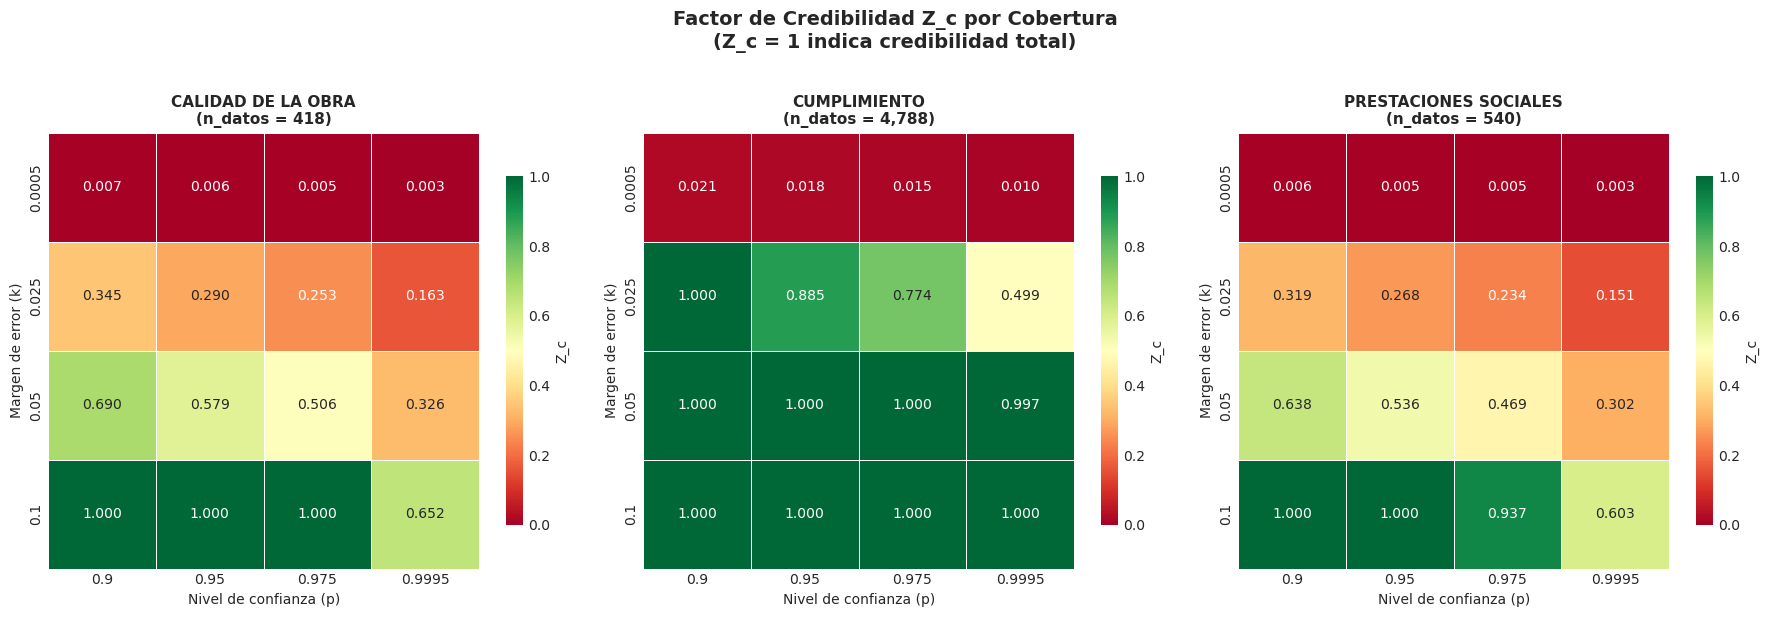

In [8]:
# ══════════════════════════════════════════════════════════════════════════════
#                      VISUALIZACIÓN: HEATMAP DE Z_c
# ══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("VISUALIZACIÓN DE FACTORES DE CREDIBILIDAD")
print("=" * 80)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Factor de Credibilidad Z_c por Cobertura\n(Z_c = 1 indica credibilidad total)', 
             fontsize=14, fontweight='bold', y=1.02)

coberturas = list(params_modelo.keys())

for idx, cob in enumerate(coberturas):
    ax = axes[idx]
    
    df_cob = df_n_req[df_n_req['Cobertura'] == cob].copy()
    pivot = df_cob.pivot(index='k', columns='p', values='Z_c')
    pivot = pivot[valores_p]
    
    # Crear heatmap
    sns.heatmap(
        pivot,
        ax=ax,
        annot=True,
        fmt='.3f',
        cmap='RdYlGn',
        vmin=0,
        vmax=1,
        linewidths=0.5,
        linecolor='white',
        cbar_kws={'label': 'Z_c', 'shrink': 0.8}
    )
    
    n_datos = momentos_por_cobertura[cob]['n_datos']
    ax.set_title(f'{cob}\n(n_datos = {n_datos:,})', fontsize=11, fontweight='bold')
    ax.set_xlabel('Nivel de confianza (p)', fontsize=10)
    ax.set_ylabel('Margen de error (k)', fontsize=10)

plt.tight_layout()

# Guardar imagen
plt.savefig('../report/images/heatmap_credibilidad.png', dpi=300, bbox_inches='tight')
print("\n✓ Imagen guardada: ../report/images/heatmap_credibilidad.png")

plt.show()

✓ Imagen guardada: ../report/images/barras_credibilidad.png


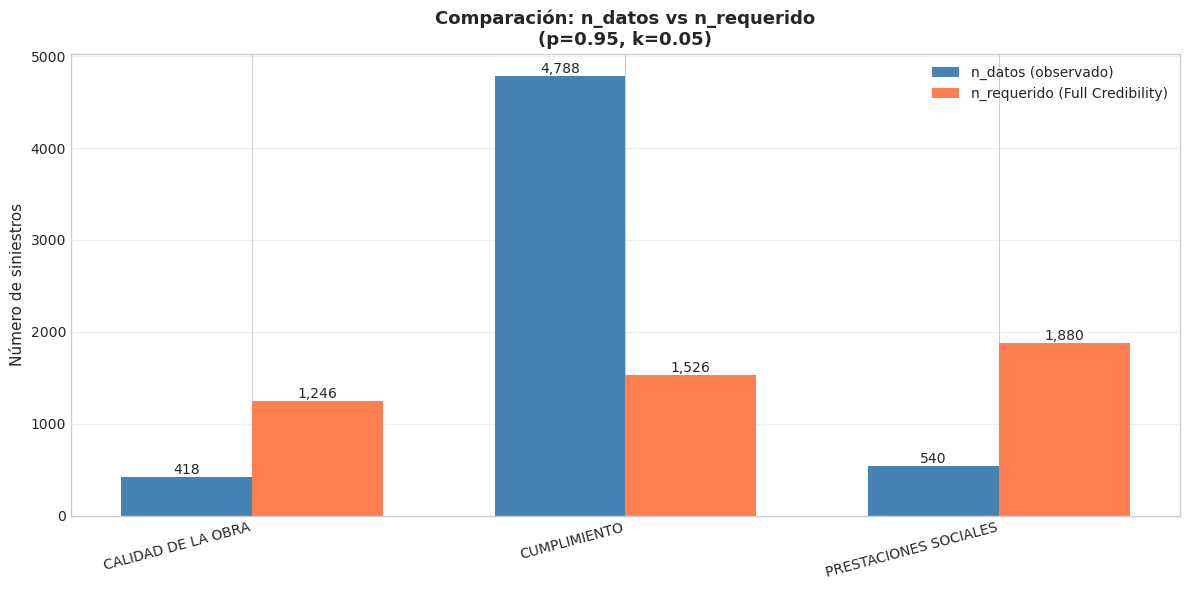


Factores de credibilidad para p=0.95, k=0.05:
------------------------------------------------------------
  CALIDAD DE LA OBRA       : Z_c = 0.5791 → Credibilidad parcial
  CUMPLIMIENTO             : Z_c = 1.0000 ✓ Credibilidad TOTAL
  PRESTACIONES SOCIALES    : Z_c = 0.5358 → Credibilidad parcial


In [9]:
# ══════════════════════════════════════════════════════════════════════════════
#                      VISUALIZACIÓN: n_datos vs n_requerido
# ══════════════════════════════════════════════════════════════════════════════

# Seleccionar un caso representativo (p=0.95, k=0.05) para visualizar
p_ejemplo = 0.95
k_ejemplo = 0.05

df_ejemplo = df_n_req[(df_n_req['p'] == p_ejemplo) & (df_n_req['k'] == k_ejemplo)].copy()

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(coberturas))
width = 0.35

bars1 = ax.bar(x - width/2, df_ejemplo['n_datos'], width, label='n_datos (observado)', color='steelblue')
bars2 = ax.bar(x + width/2, df_ejemplo['n_requerido'], width, label='n_requerido (Full Credibility)', color='coral')

ax.set_ylabel('Número de siniestros', fontsize=11)
ax.set_title(f'Comparación: n_datos vs n_requerido\n(p={p_ejemplo}, k={k_ejemplo})', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(coberturas, rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Agregar valores sobre las barras
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{int(height):,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{int(height):,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()

# Guardar imagen
plt.savefig('../report/images/barras_credibilidad.png', dpi=300, bbox_inches='tight')
print("✓ Imagen guardada: ../report/images/barras_credibilidad.png")

plt.show()

# Mostrar factores de credibilidad para este caso
print(f"\nFactores de credibilidad para p={p_ejemplo}, k={k_ejemplo}:")
print("-" * 60)
for _, row in df_ejemplo.iterrows():
    status = "✓ Credibilidad TOTAL" if row['Z_c'] >= 1.0 else f"→ Credibilidad parcial"
    print(f"  {row['Cobertura']:<25}: Z_c = {row['Z_c']:.4f} {status}")

## 7. Exportar a Excel

In [10]:
# ══════════════════════════════════════════════════════════════════════════════
#                      EXPORTAR A EXCEL
# ══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("EXPORTANDO A EXCEL")
print("=" * 80)

ruta_excel = '../data/out/full_credibility.xlsx'

with pd.ExcelWriter(ruta_excel, engine='openpyxl') as writer:
    
    # Hoja 1: Parámetros de Severidad
    df_params = pd.DataFrame([
        {
            'Cobertura': cob,
            'π': params_modelo[cob]['pi'],
            'α': params_modelo[cob]['alpha'],
            'β': params_modelo[cob]['beta'],
            'n_datos': params_modelo[cob]['n_datos'],
            'E[X]': momentos_por_cobertura[cob]['E_X'],
            'Var[X]': momentos_por_cobertura[cob]['Var_X'],
            'SD[X]': momentos_por_cobertura[cob]['SD_X'],
            'CV': momentos_por_cobertura[cob]['CV']
        }
        for cob in params_modelo.keys()
    ])
    df_params.to_excel(writer, sheet_name='Parametros_Severidad', index=False)
    print("\n✓ Hoja 'Parametros_Severidad' creada")
    
    # Hoja 2: Datos completos
    df_export = df_n_req.copy()
    df_export['n_requerido'] = df_export['n_requerido'].round(0)
    df_export.to_excel(writer, sheet_name='Datos_Completos', index=False)
    print("✓ Hoja 'Datos_Completos' creada")
    
    # Hojas 3-5: Tablas pivoteadas de n_requerido por cobertura
    for cob in params_modelo.keys():
        df_cob = df_n_req[df_n_req['Cobertura'] == cob].copy()
        pivot_n_req = df_cob.pivot(index='k', columns='p', values='n_requerido').round(0)
        pivot_n_req.columns = [f'p={p}' for p in pivot_n_req.columns]
        
        nombre_hoja = f'n_req_{cob[:15].replace(" ", "_")}'
        pivot_n_req.to_excel(writer, sheet_name=nombre_hoja)
        print(f"✓ Hoja '{nombre_hoja}' creada")
    
    # Hojas 6-8: Tablas pivoteadas de Z_c por cobertura
    for cob in params_modelo.keys():
        df_cob = df_n_req[df_n_req['Cobertura'] == cob].copy()
        pivot_zc = df_cob.pivot(index='k', columns='p', values='Z_c').round(4)
        pivot_zc.columns = [f'p={p}' for p in pivot_zc.columns]
        
        nombre_hoja = f'Zc_{cob[:17].replace(" ", "_")}'
        pivot_zc.to_excel(writer, sheet_name=nombre_hoja)
        print(f"✓ Hoja '{nombre_hoja}' creada")

print(f"\n" + "=" * 80)
print(f"✓ ARCHIVO EXCEL GUARDADO: {ruta_excel}")
print("=" * 80)

EXPORTANDO A EXCEL

✓ Hoja 'Parametros_Severidad' creada
✓ Hoja 'Datos_Completos' creada
✓ Hoja 'n_req_CALIDAD_DE_LA_O' creada
✓ Hoja 'n_req_CUMPLIMIENTO' creada
✓ Hoja 'n_req_PRESTACIONES_SO' creada
✓ Hoja 'Zc_CALIDAD_DE_LA_OBR' creada
✓ Hoja 'Zc_CUMPLIMIENTO' creada
✓ Hoja 'Zc_PRESTACIONES_SOCI' creada

✓ ARCHIVO EXCEL GUARDADO: ../data/out/full_credibility.xlsx


In [11]:
# ══════════════════════════════════════════════════════════════════════════════
#                      FORMATEO DEL EXCEL
# ══════════════════════════════════════════════════════════════════════════════

from openpyxl import load_workbook
from openpyxl.styles import Font, Alignment, Border, Side, PatternFill

print("=" * 80)
print("APLICANDO FORMATO AL EXCEL")
print("=" * 80)

# Cargar el archivo
wb = load_workbook(ruta_excel)

# Estilos
header_font = Font(bold=True, color='FFFFFF')
header_fill = PatternFill(start_color='2E86AB', end_color='2E86AB', fill_type='solid')
border = Border(
    left=Side(style='thin'),
    right=Side(style='thin'),
    top=Side(style='thin'),
    bottom=Side(style='thin')
)
center_alignment = Alignment(horizontal='center', vertical='center')

# Aplicar formato a cada hoja
for sheet_name in wb.sheetnames:
    ws = wb[sheet_name]
    
    # Formato de encabezados (primera fila)
    for cell in ws[1]:
        cell.font = header_font
        cell.fill = header_fill
        cell.alignment = center_alignment
        cell.border = border
    
    # Formato de datos
    for row in ws.iter_rows(min_row=2):
        for cell in row:
            cell.alignment = center_alignment
            cell.border = border
            # Formato numérico para decimales
            if isinstance(cell.value, float):
                if abs(cell.value) < 1:
                    cell.number_format = '0.0000'
                else:
                    cell.number_format = '#,##0'
    
    # Ajustar ancho de columnas
    for column in ws.columns:
        max_length = 0
        column_letter = column[0].column_letter
        for cell in column:
            try:
                if len(str(cell.value)) > max_length:
                    max_length = len(str(cell.value))
            except:
                pass
        adjusted_width = min(max_length + 2, 25)
        ws.column_dimensions[column_letter].width = adjusted_width
    
    print(f"✓ Formato aplicado a hoja '{sheet_name}'")

# Guardar
wb.save(ruta_excel)

print(f"\n" + "=" * 80)
print(f"✓ EXCEL FORMATEADO Y GUARDADO: {ruta_excel}")
print("=" * 80)

APLICANDO FORMATO AL EXCEL
✓ Formato aplicado a hoja 'Parametros_Severidad'
✓ Formato aplicado a hoja 'Datos_Completos'
✓ Formato aplicado a hoja 'n_req_CALIDAD_DE_LA_O'
✓ Formato aplicado a hoja 'n_req_CUMPLIMIENTO'
✓ Formato aplicado a hoja 'n_req_PRESTACIONES_SO'
✓ Formato aplicado a hoja 'Zc_CALIDAD_DE_LA_OBR'
✓ Formato aplicado a hoja 'Zc_CUMPLIMIENTO'
✓ Formato aplicado a hoja 'Zc_PRESTACIONES_SOCI'

✓ EXCEL FORMATEADO Y GUARDADO: ../data/out/full_credibility.xlsx


## 8. Resumen Final

In [12]:
# ══════════════════════════════════════════════════════════════════════════════
#                      RESUMEN FINAL
# ══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("RESUMEN FINAL: ANÁLISIS DE CREDIBILIDAD")
print("=" * 80)

print("\n" + "─" * 80)
print("1. PARÁMETROS DE SEVERIDAD POR COBERTURA")
print("─" * 80)
print(f"\n{'Cobertura':<25} {'E[X]':>12} {'Var[X]':>12} {'n_datos':>10}")
print("-" * 62)
for cob, momentos in momentos_por_cobertura.items():
    print(f"{cob:<25} {momentos['E_X']:>12.6f} {momentos['Var_X']:>12.6f} {momentos['n_datos']:>10,}")

print("\n" + "─" * 80)
print("2. TABLA DE n_REQUERIDO (MUESTRA: k=0.05)")
print("─" * 80)

for cob in params_modelo.keys():
    print(f"\n{cob}:")
    df_cob = df_n_req[(df_n_req['Cobertura'] == cob) & (df_n_req['k'] == 0.05)]
    for _, row in df_cob.iterrows():
        print(f"  p={row['p']:.4f}: n_req = {row['n_requerido']:>12,.0f} → Z_c = {row['Z_c']:.4f}")

print("\n" + "─" * 80)
print("3. CONCLUSIONES DE CREDIBILIDAD (p=0.95, k=0.05)")
print("─" * 80)

df_conclusion = df_n_req[(df_n_req['p'] == 0.95) & (df_n_req['k'] == 0.05)]

print(f"\n{'Cobertura':<25} {'n_datos':>10} {'n_req':>12} {'Z_c':>8} {'Estado':>20}")
print("-" * 80)
for _, row in df_conclusion.iterrows():
    estado = "CREDIBILIDAD TOTAL" if row['Z_c'] >= 1.0 else "Credibilidad parcial"
    print(f"{row['Cobertura']:<25} {row['n_datos']:>10,} {row['n_requerido']:>12,.0f} {row['Z_c']:>8.4f} {estado:>20}")

print("\n" + "=" * 80)
print("ARCHIVOS GENERADOS:")
print("=" * 80)
print("  1. ../data/out/full_credibility.xlsx")
print("  2. ../report/images/heatmap_credibilidad.png")
print("  3. ../report/images/barras_credibilidad.png")
print("\n✓ Análisis de Full Credibility completado")

RESUMEN FINAL: ANÁLISIS DE CREDIBILIDAD

────────────────────────────────────────────────────────────────────────────────
1. PARÁMETROS DE SEVERIDAD POR COBERTURA
────────────────────────────────────────────────────────────────────────────────

Cobertura                         E[X]       Var[X]    n_datos
--------------------------------------------------------------
CALIDAD DE LA OBRA            0.450161     0.164380        418
CUMPLIMIENTO                  0.359829     0.128646      4,788
PRESTACIONES SOCIALES         0.289993     0.102933        540

────────────────────────────────────────────────────────────────────────────────
2. TABLA DE n_REQUERIDO (MUESTRA: k=0.05)
────────────────────────────────────────────────────────────────────────────────

CALIDAD DE LA OBRA:
  p=0.9000: n_req =          878 → Z_c = 0.6900
  p=0.9500: n_req =        1,246 → Z_c = 0.5791
  p=0.9750: n_req =        1,630 → Z_c = 0.5064
  p=0.9995: n_req =        3,931 → Z_c = 0.3261

CUMPLIMIENTO:
  p=0.9